In [11]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant import xtdata
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [12]:

file_dx = 'D:\workspace\TradeX\ezMoney\database\低吸_2025-01-27.csv'
file_jl = 'D:\workspace\TradeX\ezMoney\database\接力_2025-01-27.csv'
file_zz = 'D:\workspace\TradeX\ezMoney\database\追涨_2025-01-27.csv'
files = [file_dx, file_jl, file_zz]

strategies = {}
for file in files:
    df = pd.read_csv(file)
    unique_values = df['sub_strategy_name'].unique().tolist()
    unique_key = df['strategy_name'].unique().tolist()
    strategies[unique_key[0]] = unique_values

def calculate_annualized_return(total_return, total_days):
    import math
    return math.pow(1 + total_return / total_days, 365) - 1

def caculate_returns(returns_df, row, _print = False):
    r = {}
    filter_df = returns_df[returns_df['codes_num'] > 0]
    if len(filter_df) <= 0:
        return r
    cumulative_returns = (1 + filter_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (filter_df[row].mean() - risk_free_rate) / filter_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = filter_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 365

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r
   


In [3]:
from datetime import datetime

file_m = {
    '低吸': file_dx,
    '接力': file_jl,
    '追涨': file_zz
}

period_target = {
    '回测周期': ['7d', '15d', '51m1', '412m1', '411m1', '410m1', '49m1', '48m1', '51m', '412m', '411m', '410m', '49m', '48m'],
    '回测目标': ['l1', 'l2', 'l3', 'avg', 'pl1', 'pl2', 'pl3', 'pavg']
}
current_date = datetime.now()
def get_df_by_period(period, sdf, strategy, sub_strategy):
    df = sdf[(sdf['strategy_name'] == strategy) & (sdf['sub_strategy_name'] == sub_strategy)]
    if '7d' == period:
        return df[df['date'] >= current_date - pd.Timedelta(days=7)]    
    elif '15d' == period:
        return df[df['date'] >= current_date - pd.Timedelta(days=15)]
    elif '51m1' == period:
        start_date = pd.to_datetime('2025-01-01')
        return df[df['date'] >= start_date]
    elif '412m1' == period:
        start_date = pd.to_datetime('2024-12-01')
        return df[df['date'] >= start_date]
    elif '411m1' == period:
        start_date = pd.to_datetime('2024-11-01')
        return df[df['date'] >= start_date]
    elif '410m1' == period:
        start_date = pd.to_datetime('2024-10-01')
        return df[df['date'] >= start_date]
    elif '49m1' == period:
        start_date = pd.to_datetime('2024-09-01')
        return df[df['date'] >= start_date]
    elif '48m1' == period:
        start_date = pd.to_datetime('2024-08-01')
        return df[df['date'] >= start_date]
    elif '51m' == period:
        start_date = pd.to_datetime('2025-01-01')
        end_date = pd.to_datetime('2025-01-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '412m' == period:
        start_date = pd.to_datetime('2024-12-01')
        end_date = pd.to_datetime('2024-12-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '411m' == period:
        start_date = pd.to_datetime('2024-11-01')
        end_date = pd.to_datetime('2024-11-30')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '410m' == period:
        start_date = pd.to_datetime('2024-10-01')
        end_date = pd.to_datetime('2024-10-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '49m' == period:
        start_date = pd.to_datetime('2024-09-01')
        end_date = pd.to_datetime('2024-09-30')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '48m' == period:
        start_date = pd.to_datetime('2024-08-01')
        end_date = pd.to_datetime('2024-08-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    else:
        return df

target_row = {
    'l1': 'first_return',
    'l2': 'top2_return',
    'l3': 'top3_return',
    'avg': 'return',
    'pl1': 'p_first_return',
    'pl2': 'p_top2_return',
    'pl3': 'p_top3_return',
    'pavg': 'p_return'
}


columns = {
    '交易名称': 'string',
    '子交易名称': 'string',
    '回测周期': 'string',
    '回测目标': 'string',
    '最大回撤': 'double',
    '夏普比率': 'double',
    '年化收益率': 'double',
    '总收益率': 'double',
    '波动率': 'double',
    '总盈亏': 'double',
    '成功次数': 'int64',
    '失败次数': 'int64',
    '胜率': 'double',
    '总天数': 'int64',
    '总交易次数': 'int64',
    '交易频率': 'double',
    '平均盈利': 'double',
    '平均亏损': 'double',
    '最大盈利': 'double',
    '最大亏损': 'double',
    '盈亏比': 'double',
    '凯利公式最佳仓位': 'double'
}

eval_df = pd.DataFrame(columns=columns.keys()).astype(columns)

for strategy, sub_strategies in strategies.items():
    file = file_m[strategy]
    df = pd.read_csv(file, dtype={'code': 'string'})
    df['date']  = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df['p_first_return'] = df['first_return'] * df['position']
    df['p_top2_return'] = df['top2_return'] * df['position']
    df['p_top3_return'] = df['top3_return'] * df['position']
    df['p_return'] = df['return'] * df['position']
    
    for sub_strategy in sub_strategies:
        for period in period_target['回测周期']:
            print(f"开始评估..., 策略-{strategy} 子策略-{sub_strategy} 日期-{period}")
            ndf = get_df_by_period(period, df, strategy, sub_strategy)
            for target in period_target['回测目标']:
                dt = caculate_returns(ndf, target_row[target])
                if not dt or len(dt) == 0:
                    print(f"策略-{strategy} 子策略-{sub_strategy} 日期-{period} 目标-{target} 结果为空")
                    continue
                dt['交易名称'] = strategy
                dt['子交易名称'] = sub_strategy
                dt['回测周期'] = period
                dt['回测目标'] = target
                cdf = pd.DataFrame([dt])
                eval_df = pd.concat([eval_df, cdf], ignore_index=True)

eval_df.to_csv(r'D:\workspace\TradeX\ezMoney\database\eval_results\eval_0127.csv')

开始评估..., 策略-低吸 子策略-绿盘低吸 日期-7d
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-15d
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-51m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-412m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-411m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-410m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-49m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-48m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-51m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-412m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-411m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-410m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-49m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-48m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-7d
开始评估..., 策略-低吸 子策略-首红断低吸 日期-15d
开始评估..., 策略-低吸 子策略-首红断低吸 日期-51m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-412m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-411m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-410m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-49m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-48m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-51m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-412m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-411m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-410m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-49m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-48m
开始评估..., 策略-低吸 子策略-红断低吸 日期-7d
开始评估..., 策略-低吸 子策略-红断低吸 日期-15d
开始评估..., 策略-低吸 子策略-红断低吸 日期-51m1
开始评

In [13]:
df = pd.read_csv(r'D:\workspace\TradeX\ezMoney\database\eval_results\eval_0127.csv')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
df= df[df['回测目标'] == 'l1'] 
x = df[(df['总交易次数'] >= 3) & (df['回测周期'] == '48m1')].sort_values(by='总收益率', ascending=False)
x[(x['胜率'] > 0.5) & (x['总收益率'] > 0.1)]

,Unnamed: 0,交易名称,子交易名称,回测周期,回测目标,最大回撤,夏普比率,年化收益率,总收益率,波动率,总盈亏,成功次数,失败次数,胜率,总天数,总交易次数,交易频率,平均盈利,平均亏损,最大盈利,最大亏损,盈亏比,凯利公式最佳仓位
4336,4336,接力,首板打板,48m1,l1,-0.175168,0.802110,444.286252,143.632268,0.079864,143.500366,67,16,0.807229,118,83,1.421687,0.094017,-0.057382,0.195402,-0.175168,1.638452,0.689575
3672,3672,接力,中高位连板打板,48m1,l1,-0.265375,0.448108,13.034457,4.213879,0.116154,4.093661,23,13,0.638889,118,36,3.277778,0.128610,-0.079400,0.283622,-0.211743,1.619775,0.415950
2328,2328,低吸,低位N字低吸,48m1,l1,-0.241133,0.291503,10.861418,3.511362,0.067063,3.498029,53,33,0.616279,118,86,1.372093,0.053430,-0.034274,0.273437,-0.109785,1.558930,0.370135
4224,4224,接力,孕线,48m1,l1,-0.244271,0.183808,6.974101,2.254641,0.074216,2.203430,59,46,0.561905,118,105,1.123810,0.057388,-0.041875,0.328554,-0.154307,1.370457,0.242234
4000,4000,接力,N半,48m1,l1,-0.257194,0.192542,6.172959,1.995641,0.078780,1.989012,50,37,0.574713,118,87,1.356322,0.063458,-0.048859,0.303347,-0.132800,1.298820,0.247271
1600,1600,低吸,低位断板低吸,48m1,l1,-0.310413,0.184581,4.704291,1.520839,0.073894,1.458981,43,41,0.511905,118,84,1.404762,0.064920,-0.040143,0.206320,-0.134454,1.617233,0.210096
504,504,低吸,低位低吸,48m1,l1,-0.236986,0.152905,4.457182,1.440952,0.065002,1.438728,63,50,0.557522,118,113,1.044248,0.050895,-0.041665,0.203822,-0.109785,1.221530,0.195290
2872,2872,低吸,低位孕线低吸,48m1,l1,-0.389972,0.174643,3.400718,1.099410,0.057876,1.115140,47,38,0.552941,118,85,1.388235,0.043804,-0.031037,0.230082,-0.093023,1.411327,0.236176
1928,1928,低吸,首绿断低吸,48m1,l1,-0.549273,0.103328,2.091494,0.676154,0.082957,0.614296,50,47,0.515464,118,97,1.216495,0.065387,-0.051870,0.303347,-0.190088,1.260594,0.131093
168,168,低吸,首红断低吸,48m1,l1,-0.385228,0.127022,2.070855,0.669482,0.075169,0.615295,38,36,0.513514,118,74,1.594595,0.062171,-0.045733,0.220228,-0.173636,1.359437,0.155655


In [90]:
file_dx = 'D:\workspace\TradeX\ezMoney\database\低吸_2025-01-27.csv'
file_jl = 'D:\workspace\TradeX\ezMoney\database\接力_2025-01-27.csv'
file_zz = 'D:\workspace\TradeX\ezMoney\database\追涨_2025-01-27.csv'

df = pd.read_csv(file_jl)
df = df[df['sub_strategy_name'] == 'N半']
df.set_index('date', inplace=True)
df['cumulative_returns'] = (1 + df['return']).cumprod()
df['p_return'] = df['return'] * df['position']
df['p_cumulative_returns'] = (1 + df['p_return']).cumprod()
df['first_cumulative_returns'] = (1 + df['first_return']).cumprod()
df['p_first_return'] = df['first_return'] * df['position']
df['p_first_cumulative_returns'] = (1 + df['p_first_return']).cumprod()
df['p3_return'] = df['return'] * 0.1
df['p3_cumulative_returns'] = (1 + df['p3_return']).cumprod()
df['p3_first_return'] = df['first_return'] * 0.15
df['p3_first_cumulative_returns'] = (1 + df['p3_first_return']).cumprod()
df_g_zero = df[df['codes_num'] > 0]

In [91]:
print("return:")
caculate_returns(df_g_zero, 'return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -27.36%
夏普比率: 0.14
总收益率: 97.27%
年化收益率: 394.48%
波动率: 6.67%
总盈亏: 96.61%
成功次数: 44
失败次数: 45
总天数: 90
总交易次数: 89
交易频率: 101.12%
胜率: 49.44%
平均盈利: 5.68%
平均亏损: -3.63%
最大盈利: 30.33%
最大亏损: -11.16%
盈亏比: 1.57
凯利公式最佳仓位: 17.16%
-----------------------------------------------------


In [92]:
print("p return:")
caculate_returns(df_g_zero, 'p_return', _print=True)
print('-----------------------------------------------------')

p return:
最大回撤: -18.69%
夏普比率: 0.19
总收益率: 125.00%
年化收益率: 506.93%
波动率: 5.34%
总盈亏: 124.77%
成功次数: 44
失败次数: 45
总天数: 90
总交易次数: 89
交易频率: 101.12%
胜率: 49.44%
平均盈利: 4.18%
平均亏损: -2.02%
最大盈利: 30.33%
最大亏损: -11.16%
盈亏比: 2.07
凯利公式最佳仓位: 24.99%
-----------------------------------------------------


In [93]:
print("first return:")
caculate_returns(df_g_zero, 'first_return', _print=True)
print('-----------------------------------------------------')

first return:
最大回撤: -25.72%
夏普比率: 0.19
总收益率: 199.56%
年化收益率: 809.34%
波动率: 7.88%
总盈亏: 198.90%
成功次数: 50
失败次数: 37
总天数: 90
总交易次数: 87
交易频率: 103.45%
胜率: 57.47%
平均盈利: 6.35%
平均亏损: -4.89%
最大盈利: 30.33%
最大亏损: -13.28%
盈亏比: 1.30
凯利公式最佳仓位: 24.73%
-----------------------------------------------------


In [94]:
print("p first_return:")
caculate_returns(df_g_zero, 'p_first_return', _print=True)
print('-----------------------------------------------------')

p first_return:
最大回撤: -20.61%
夏普比率: 0.21
总收益率: 159.11%
年化收益率: 645.27%
波动率: 5.84%
总盈亏: 158.88%
成功次数: 50
失败次数: 37
总天数: 90
总交易次数: 87
交易频率: 103.45%
胜率: 57.47%
平均盈利: 4.24%
平均亏损: -2.76%
最大盈利: 30.33%
最大亏损: -10.54%
盈亏比: 1.53
凯利公式最佳仓位: 29.74%
-----------------------------------------------------


In [95]:
print("p3 return:")
caculate_returns(df_g_zero, 'p3_return', _print=True)
print('-----------------------------------------------------')

p3 return:
最大回撤: -2.99%
夏普比率: 0.14
总收益率: 8.85%
年化收益率: 35.89%
波动率: 0.67%
总盈亏: 8.78%
成功次数: 44
失败次数: 45
总天数: 90
总交易次数: 89
交易频率: 101.12%
胜率: 49.44%
平均盈利: 0.57%
平均亏损: -0.36%
最大盈利: 3.03%
最大亏损: -1.12%
盈亏比: 1.57
凯利公式最佳仓位: 17.16%
-----------------------------------------------------


In [96]:
print("p3 first return:")
caculate_returns(df_g_zero, 'p3_first_return', _print=True)
print('-----------------------------------------------------')

p3 first return:
最大回撤: -4.08%
夏普比率: 0.19
总收益率: 21.95%
年化收益率: 89.00%
波动率: 1.18%
总盈亏: 21.85%
成功次数: 50
失败次数: 37
总天数: 90
总交易次数: 87
交易频率: 103.45%
胜率: 57.47%
平均盈利: 0.95%
平均亏损: -0.73%
最大盈利: 4.55%
最大亏损: -1.99%
盈亏比: 1.30
凯利公式最佳仓位: 24.73%
-----------------------------------------------------


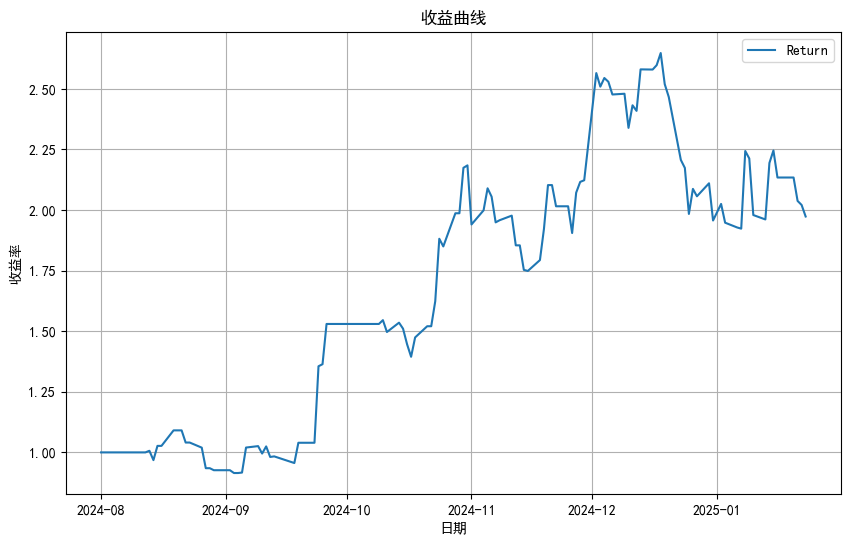

In [97]:
plot(df, 'cumulative_returns')

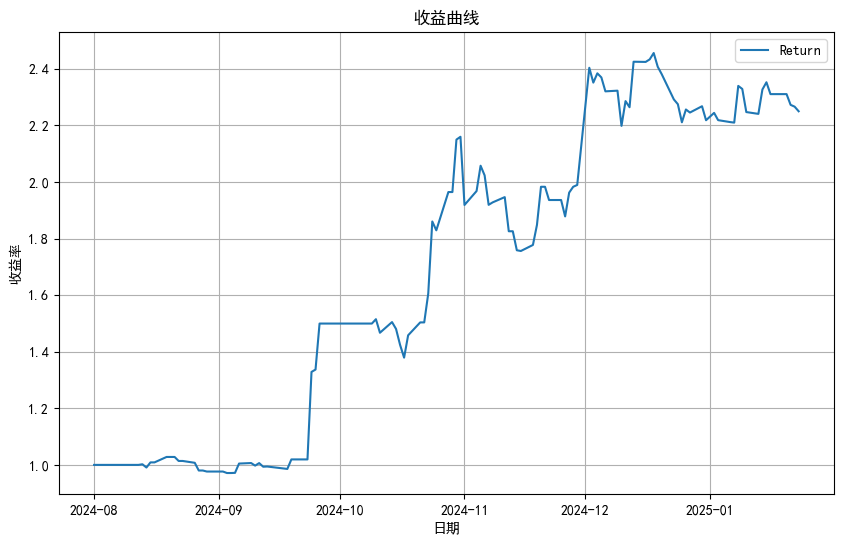

In [98]:
plot(df, 'p_cumulative_returns')

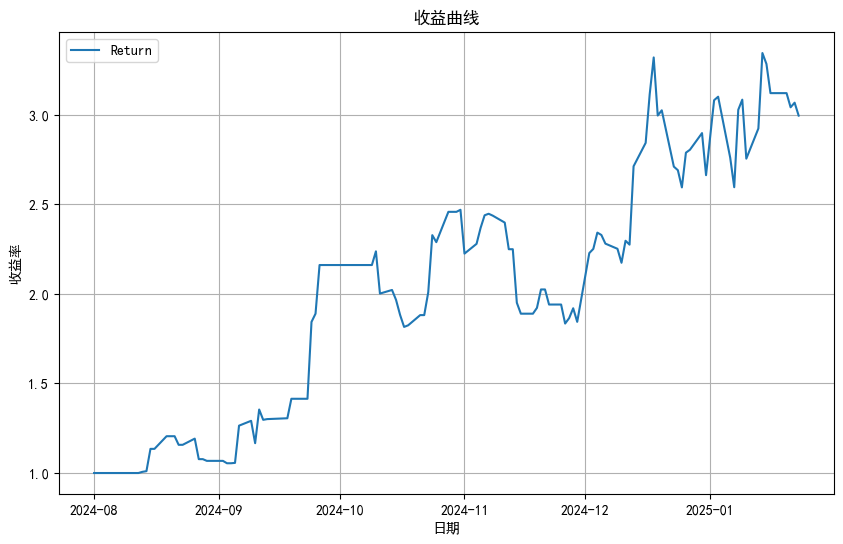

In [99]:
plot(df, 'first_cumulative_returns')

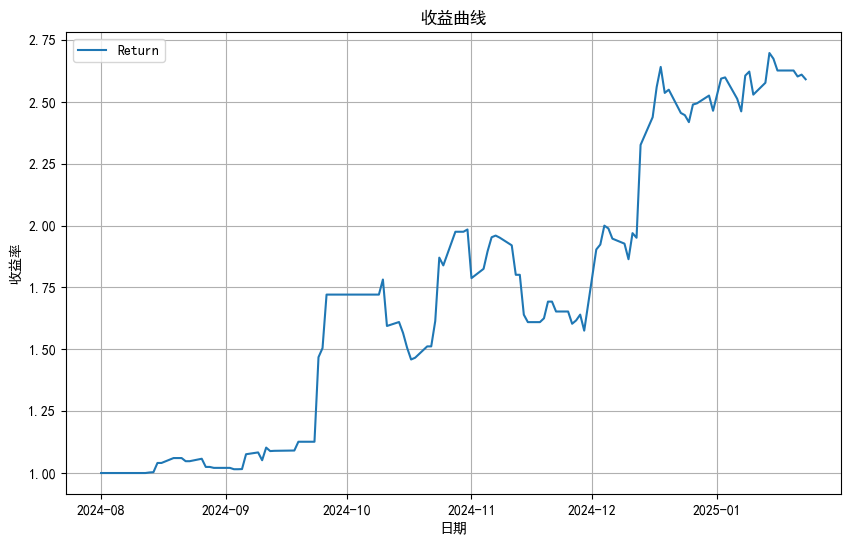

In [100]:
plot(df, 'p_first_cumulative_returns')

In [101]:
len(df_g_zero)

90

In [102]:
len(df)

118

In [103]:
len(df)/len(df_g_zero)

1.3111111111111111

In [104]:
df_after_date = df.loc[df.index >= '2024-11-01']
df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
df_after_date['p_cumulative_returns'] = (1 + df_after_date['p_return']).cumprod()
df_after_date['first_cumulative_returns'] = (1 + df_after_date['first_return']).cumprod()
df_after_date['p_first_return'] = df_after_date['first_return'] * df_after_date['position']
df_after_date['p_first_cumulative_returns'] = (1 + df_after_date['p_first_return']).cumprod()
df_after_date_g_zero = df_after_date[df_after_date['codes_num'] > 0]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_47660\3900913857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_47660\3900913857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_47660\3900913857.py:4: SettingWithCopyWarning: 
A value is t

In [105]:
print("return:")
caculate_returns(df_after_date_g_zero, 'return', True)
print('-------------------------------------------------------------------')

return:
最大回撤: -27.36%
夏普比率: -0.00
总收益率: -9.66%
年化收益率: -65.27%
波动率: 6.14%
总盈亏: 1.51%
成功次数: 23
失败次数: 31
总天数: 54
总交易次数: 54
交易频率: 100.00%
胜率: 42.59%
平均盈利: 5.11%
平均亏损: -3.81%
最大盈利: 20.82%
最大亏损: -11.16%
盈亏比: 1.34
凯利公式最佳仓位: -0.17%
-------------------------------------------------------------------


In [106]:
print("p return:")
caculate_returns(df_after_date_g_zero, 'p_return', True)
print("---------------------------------------------------------------------")


p return:
最大回撤: -14.65%
夏普比率: 0.04
总收益率: 4.17%
年化收益率: 28.22%
波动率: 4.32%
总盈亏: 15.34%
成功次数: 23
失败次数: 31
总天数: 54
总交易次数: 54
交易频率: 100.00%
胜率: 42.59%
平均盈利: 3.33%
平均亏损: -2.19%
最大盈利: 20.82%
最大亏损: -11.16%
盈亏比: 1.52
凯利公式最佳仓位: 4.91%
---------------------------------------------------------------------


In [107]:
print("first return:")
caculate_returns(df_after_date_g_zero, 'first_return', True)
print("----------------------------------------------------------------------")


first return:
最大回撤: -25.05%
夏普比率: 0.08
总收益率: 21.29%
年化收益率: 143.92%
波动率: 7.40%
总盈亏: 31.20%
成功次数: 27
失败次数: 26
总天数: 54
总交易次数: 53
交易频率: 101.89%
胜率: 50.94%
平均盈利: 5.99%
平均亏损: -4.94%
最大盈利: 20.82%
最大亏损: -13.28%
盈亏比: 1.21
凯利公式最佳仓位: 10.52%
----------------------------------------------------------------------


In [108]:
print("p first_return:")
caculate_returns(df_after_date_g_zero, 'p_first_return', True)
print("-----------------------------------------------------------------------")

p first_return:
最大回撤: -19.61%
夏普比率: 0.12
总收益率: 30.59%
年化收益率: 206.77%
波动率: 5.10%
总盈亏: 40.50%
成功次数: 27
失败次数: 26
总天数: 54
总交易次数: 53
交易频率: 101.89%
胜率: 50.94%
平均盈利: 3.86%
平均亏损: -2.73%
最大盈利: 20.82%
最大亏损: -9.91%
盈亏比: 1.41
凯利公式最佳仓位: 16.27%
-----------------------------------------------------------------------


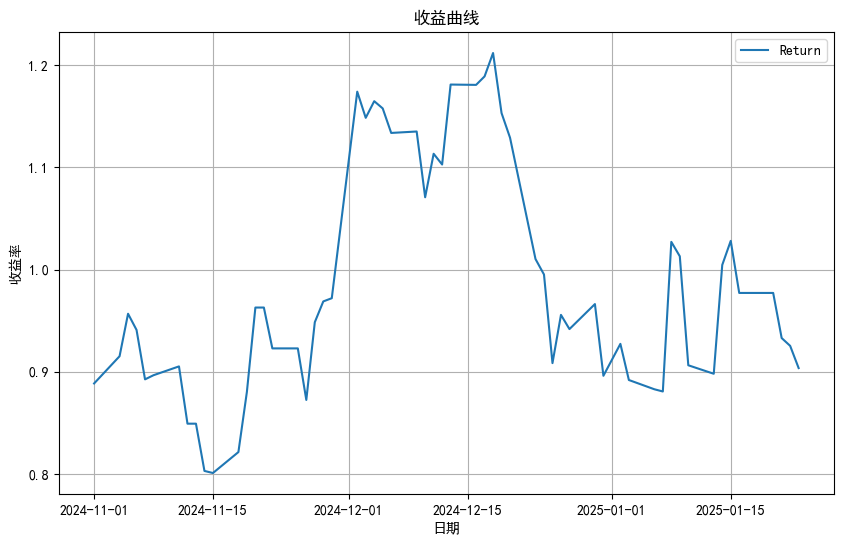

In [109]:
plot(df_after_date, 'cumulative_returns')

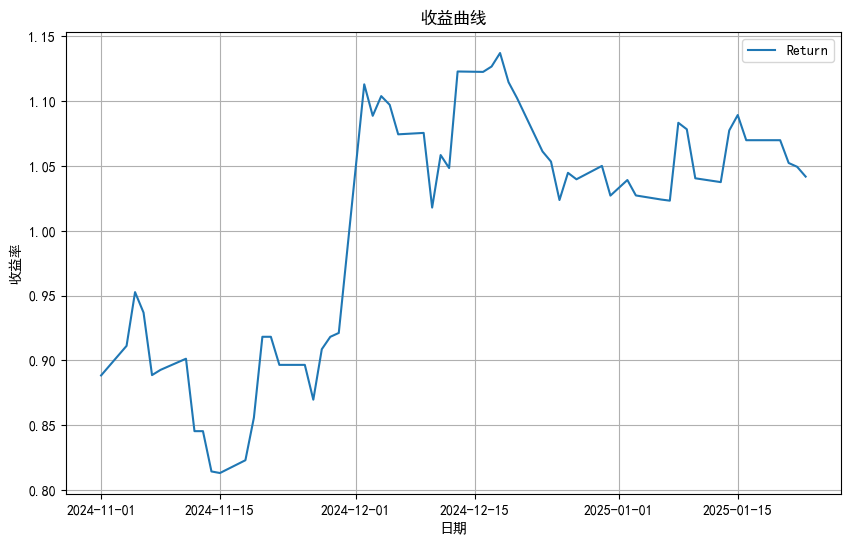

In [110]:
plot(df_after_date, 'p_cumulative_returns')

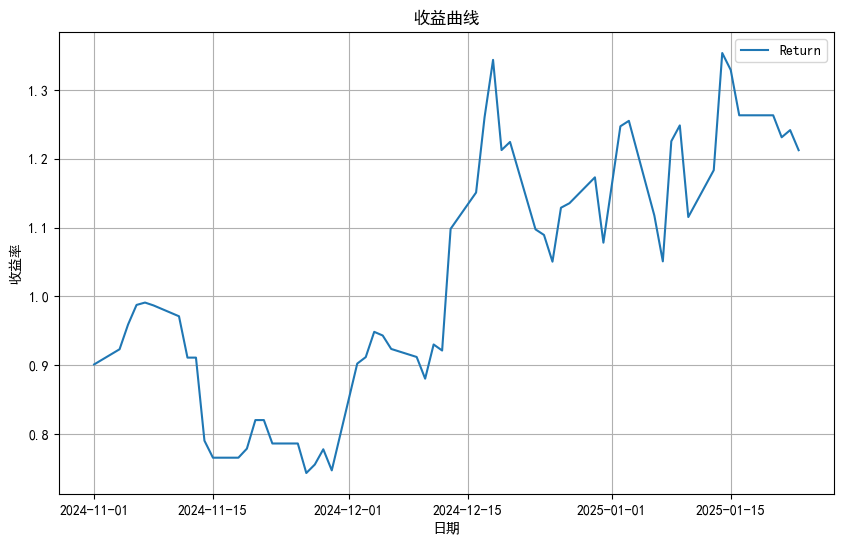

In [111]:
plot(df_after_date, 'first_cumulative_returns')

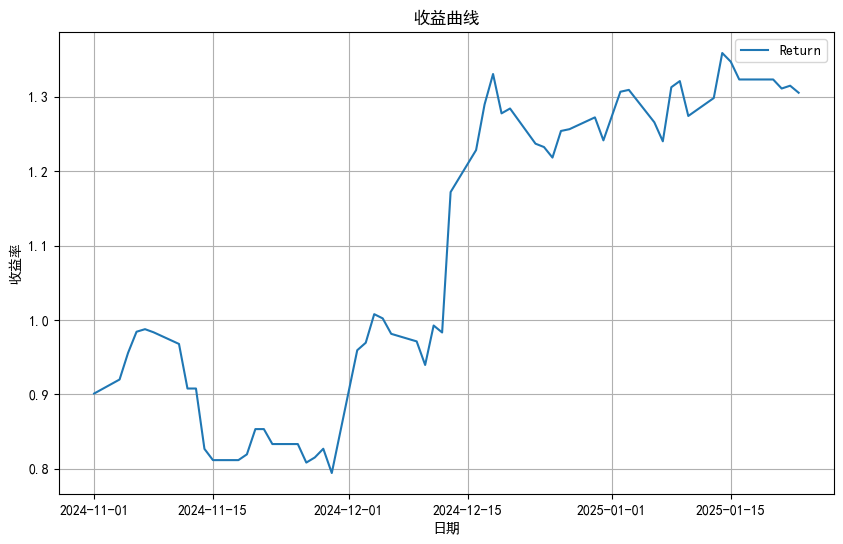

In [112]:
plot(df_after_date, 'p_first_cumulative_returns')

In [113]:
0.008906*0.3

0.0026718

In [114]:
3.61*0.3

1.083

In [39]:
df_g_zero

,code,strategy_name,sub_strategy_name,return,max_return,first_return,top2_return,top3_return,position,codes_num,trendScore,shortLineScore,shortLineScoreChange,cumulative_returns,p_return,p_cumulative_returns,first_cumulative_returns,p_first_return,p_first_cumulative_returns,p3_return,p3_cumulative_returns,p3_first_return,p3_first_cumulative_returns
date,,,,,,,,,,,,,,,,,,,,,,,
2024-08-01,605178.0,低吸,低位低吸,0.002224,0.002224,0.002224,0.002224,0.002224,1.000000,1,15.83,53.76,25.35,1.002224,0.002224,1.002224,1.002224,0.002224,1.002224,0.000222,1.000222,0.000334,1.000334
2024-08-02,603082.0,低吸,低位低吸,0.033478,0.033478,0.033478,0.033478,0.033478,0.927208,1,17.33,53.90,0.14,1.035776,0.031041,1.033334,1.035776,0.031041,1.033334,0.003348,1.003571,0.005022,1.005357
2024-08-05,1316.0,低吸,低位低吸,-0.037152,-0.037152,-0.037152,-0.037152,-0.037152,0.675140,1,10.36,37.66,-16.24,0.997295,-0.025083,1.007415,0.997295,-0.025083,1.007415,-0.003715,0.999842,-0.005573,0.999754
2024-08-06,16.0,低吸,低位低吸,-0.097473,-0.097473,-0.097473,-0.097473,-0.097473,0.551162,1,-5.12,9.67,-27.99,0.900086,-0.053723,0.953294,0.900086,-0.053723,0.953294,-0.009747,0.990097,-0.014621,0.985137
2024-08-07,2278.0,低吸,低位低吸,0.041943,0.041943,0.041943,0.041943,0.041943,0.396782,1,-13.50,-18.09,-27.76,0.937838,0.016642,0.969158,0.937838,0.016642,0.969158,0.004194,0.994249,0.006291,0.991335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17,3042.0,低吸,低位低吸,-0.026283,-0.026283,-0.026283,-0.026283,-0.026283,0.560071,1,16.56,30.03,20.65,2.620187,-0.014720,2.405669,2.620187,-0.014720,2.405669,-0.002628,1.123770,-0.003942,1.189183
2025-01-20,603808.0,低吸,低位低吸,-0.017677,-0.017677,-0.017677,-0.017677,-0.017677,0.664101,1,4.97,22.67,-7.36,2.573871,-0.011739,2.377428,2.573871,-0.011739,2.377428,-0.001768,1.121784,-0.002652,1.186029
2025-01-21,2291.0,低吸,低位低吸,-0.019461,-0.019461,-0.019461,-0.019461,-0.019461,0.363078,1,-2.88,-26.12,-48.79,2.523780,-0.007066,2.360629,2.523780,-0.007066,2.360629,-0.001946,1.119600,-0.002919,1.182567


# 不按凯利公式调仓
## return
- 最大回撤: -20.73%
- 夏普比率: 0.09
- 总收益率: 14.75%
- 波动率: 5.90%
- 最大收益: 16.11%
- 总盈亏: 11.40%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 5.08%
- 平均亏损: -4.25%
- 最大盈利: 16.11%
- 最大亏损: -8.12%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p return
- 最大回撤: -13.76%
- 夏普比率: 0.19
- 总收益率: 28.26%
- 波动率: 3.91%
- 最大收益: 14.37%
- 总盈亏: 25.16%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 3.46%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.64
- 凯利公式最佳仓位: 21.61%

## first return
- 最大回撤: -13.93%
- 夏普比率: 0.12
- 总收益率: 23.89%
- 波动率: 5.88%
- 最大收益: 16.11%
- 总盈亏: 20.55%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 4.98%
- 平均亏损: -4.23%
- 最大盈利: 16.11%
- 最大亏损: -9.67%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%

## p first_return
- 最大回撤: -13.74%
- 夏普比率: 0.20
- 总收益率: 31.27%
- 波动率: 3.85%
- 最大收益: 14.37%
- 总盈亏: 28.17%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 3.30%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.55
- 凯利公式最佳仓位: 24.50%

## p3 return
- 最大回撤: -6.54%
- 夏普比率: 0.09
- 总收益率: 5.59%
- 波动率: 1.77%
- 最大收益: 4.83%
- 总盈亏: 4.58%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 1.52%
- 平均亏损: -1.27%
- 最大盈利: 4.83%
- 最大亏损: -2.44%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p3 first return
- 最大回撤: -4.28%
- 夏普比率: 0.12
- 总收益率: 8.05%
- 波动率: 1.76%
- 最大收益: 4.83%
- 总盈亏: 7.04%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 1.50%
- 平均亏损: -1.27%
- 最大盈利: 4.83%
- 最大亏损: -2.90%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%


<!-- return:
最大回撤: -20.73%
夏普比率: 0.04
总收益率: 1.99%
波动率: 5.35%
最大收益: 10.37%
总盈亏: 5.31%
None
p return:
最大回撤: -7.64%
夏普比率: 0.21
总收益率: 14.38%
波动率: 3.52%
最大收益: 10.37%
总盈亏: 17.71%
None
first return:
最大回撤: -12.83%
夏普比率: 0.13
总收益率: 12.16%
波动率: 5.23%
最大收益: 10.37%
总盈亏: 15.49%
None
p first_return:
最大回撤: -4.61%
夏普比率: 0.26
总收益率: 18.58%
波动率: 3.44%
最大收益: 10.37%
总盈亏: 21.91%
None -->


# 按照凯利公式调仓
## return
- 最大回撤: -20.73%
- 夏普比率: 0.09
- 总收益率: 14.75%
- 波动率: 5.90%
- 最大收益: 16.11%
- 总盈亏: 11.40%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 5.08%
- 平均亏损: -4.25%
- 最大盈利: 16.11%
- 最大亏损: -8.12%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p return
- 最大回撤: -13.76%
- 夏普比率: 0.19
- 总收益率: 28.26%
- 波动率: 3.91%
- 最大收益: 14.37%
- 总盈亏: 25.16%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 3.46%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.64
- 凯利公式最佳仓位: 21.61%

## first return
- 最大回撤: -13.93%
- 夏普比率: 0.12
- 总收益率: 23.89%
- 波动率: 5.88%
- 最大收益: 16.11%
- 总盈亏: 20.55%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 4.98%
- 平均亏损: -4.23%
- 最大盈利: 16.11%
- 最大亏损: -9.67%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%

## p first_return
- 最大回撤: -13.74%
- 夏普比率: 0.20
- 总收益率: 31.27%
- 波动率: 3.85%
- 最大收益: 14.37%
- 总盈亏: 28.17%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 3.30%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.55
- 凯利公式最佳仓位: 24.50%

## p3 return
- 最大回撤: -2.21%
- 夏普比率: 0.09
- 总收益率: 1.96%
- 波动率: 0.59%
- 最大收益: 1.61%
- 总盈亏: 1.62%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 0.51%
- 平均亏损: -0.42%
- 最大盈利: 1.61%
- 最大亏损: -0.81%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p3 first return
- 最大回撤: -2.15%
- 夏普比率: 0.12
- 总收益率: 4.10%
- 波动率: 0.88%
- 最大收益: 2.42%
- 总盈亏: 3.59%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 0.75%
- 平均亏损: -0.63%
- 最大盈利: 2.42%
- 最大亏损: -1.45%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%


# 10月15号后
## return
- 最大回撤: -20.73%
- 夏普比率: 0.04
- 总收益率: 1.99%
- 波动率: 5.35%
- 最大收益: 10.37%
- 总盈亏: 5.31%
- 成功次数: 10
- 总次数: 19
- 胜率: 52.63%
- 平均盈利: 4.50%
- 平均亏损: -4.48%
- 最大盈利: 10.37%
- 最大亏损: -8.12%
- 盈亏比: 1.00
- 凯利公式最佳仓位: 5.48%

## p return
- 最大回撤: -7.64%
- 夏普比率: 0.21
- 总收益率: 14.38%
- 波动率: 3.52%
- 最大收益: 10.37%
- 总盈亏: 17.71%
- 成功次数: 10
- 总次数: 19
- 胜率: 52.63%
- 平均盈利: 3.30%
- 平均亏损: -2.04%
- 最大盈利: 10.37%
- 最大亏损: -4.61%
- 盈亏比: 1.62
- 凯利公式最佳仓位: 23.34%

## first return
- 最大回撤: -12.83%
- 夏普比率: 0.13
- 总收益率: 12.16%
- 波动率: 5.23%
- 最大收益: 10.37%
- 总盈亏: 15.49%
- 成功次数: 11
- 总次数: 19
- 胜率: 57.89%
- 平均盈利: 4.49%
- 平均亏损: -4.41%
- 最大盈利: 10.37%
- 最大亏损: -8.12%
- 盈亏比: 1.02
- 凯利公式最佳仓位: 16.54%

## p first_return
- 最大回撤: -4.61%
- 夏普比率: 0.26
- 总收益率: 18.58%
- 波动率: 3.44%
- 最大收益: 10.37%
- 总盈亏: 21.91%
- 成功次数: 11
- 总次数: 19
- 胜率: 57.89%
- 平均盈利: 3.13%
- 平均亏损: -2.03%
- 最大盈利: 10.37%
- 最大亏损: -4.61%
- 盈亏比: 1.54
- 凯利公式最佳仓位: 30.60%
